# (연구&서연) Ebayesthresh Layer

최규빈  
2024-08-14

In [2]:
pip install --no-deps git+https://github.com/seoyeonc/ebayesthresh_torch.git -U

  Cloning https://github.com/seoyeonc/ebayesthresh_torch.git to /tmp/pip-req-build-zyg9_r7k
  Running command git clone --filter=blob:none --quiet https://github.com/seoyeonc/ebayesthresh_torch.git /tmp/pip-req-build-zyg9_r7k
  Resolved https://github.com/seoyeonc/ebayesthresh_torch.git to commit da73db669a7965c26397949b7594f4ee34cfa73a
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.

# Import

In [3]:
import ebayesthresh_torch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 예제를 위해 필요한 함수 정의

In [5]:
def make_Psi(T):
    W = torch.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif torch.abs(torch.tensor(i - j)) <= 1 : 
                W[i,j] = 1
    d = W.sum(dim=1)
    D = torch.diag(d)
    L = torch.diag(1/torch.sqrt(d)) @ (D-W) @ torch.diag(1/torch.sqrt(d))
    lamb, Psi = torch.linalg.eigh(L)
    return Psi

# Example

In [6]:
T = 100
x = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
y = y_true + np.random.normal(size=T)

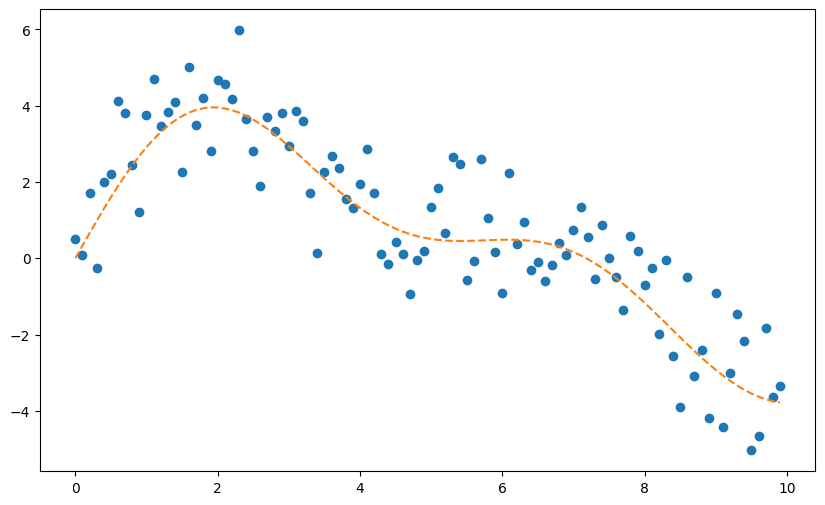

In [7]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.plot(x,y_true,'--')

In [8]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

In [9]:
fbar_threshed = ebayesthresh_torch.ebayesthresh(fbar[:,0])

/home/cgb2/anaconda3/envs/EbayesthreshLayer/lib/python3.12/site-packages/ebayesthresh_torch/utils.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.isnan(torch.tensor(sdev)):

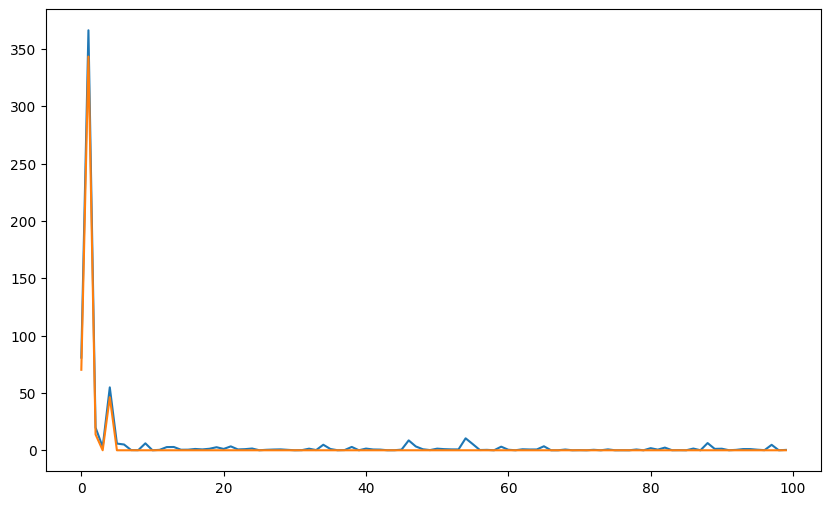

In [10]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

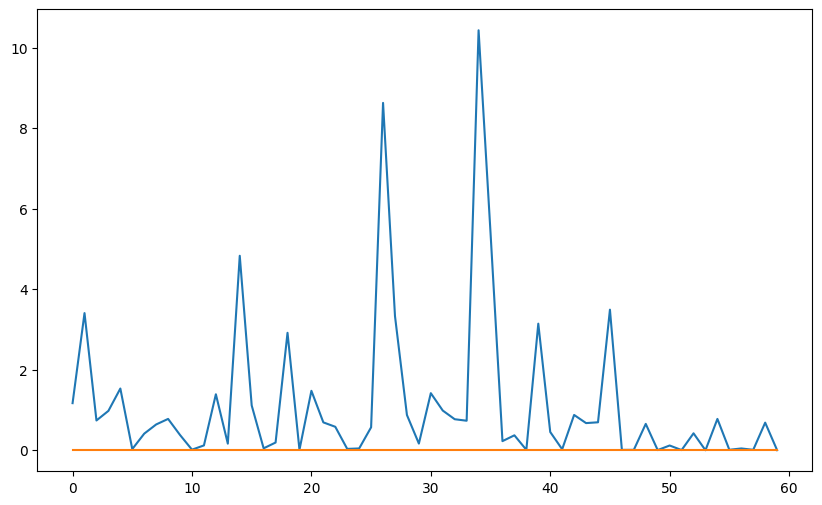

In [11]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

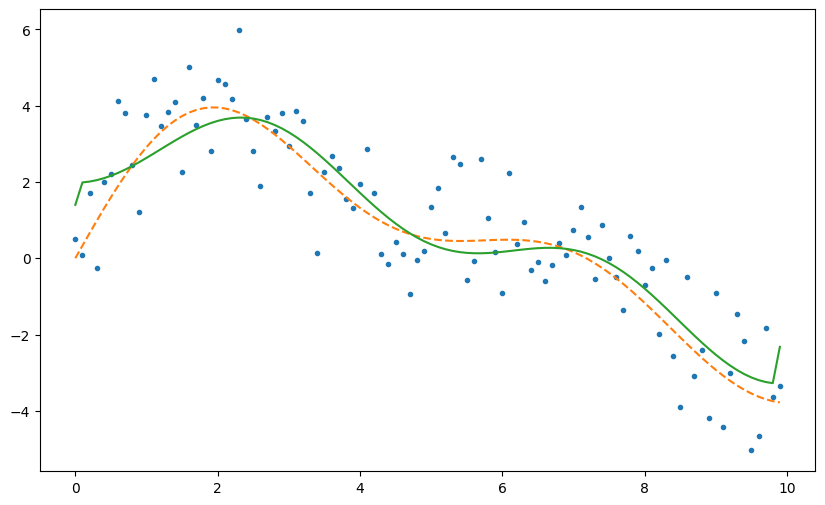

In [12]:
yhat = Psi @ fbar_threshed.float() # inverse dft
plt.figure(figsize=(10,6))
plt.plot(x,y,'.')
plt.plot(x,y_true,'--')
plt.plot(x,yhat)

# 사용자 함수 정의

In [25]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.bayesfac = kwargs.get("bayesfac",True)
        self.verbose = kwargs.get('verbose', True)
        self.threshrule = kwargs.get('threshrule', 'median')
        self.universalthresh = kwargs.get('universalthresh', True)
        self.stabadjustment = kwargs.get('stabadjustment', None)
        self.prior = kwargs.get('prior', 'laplace')
        self.bayesfac = kwargs.get('bayesfac', False) 
        #--#
        self.a = torch.tensor(0.1,requires_grad=True); self.a.data = torch.tensor(kwargs.get('a', 0.5)).float()
        self.sdev = torch.tensor(0.1,requires_grad=True); self.sdev.data =  torch.tensor(kwargs.get('sdev', 0.5)).float()
        #prior="laplace", a = 0.5, bayesfac = False, sdev = None, verbose = True, threshrule = "median", universalthresh = True, stabadjustment = None
    def forward(self,x):
        out = ebayesthresh_torch.ebayesthresh(
            x,
            self.prior, 
            a=self.a, 
            bayesfac=self.bayesfac, 
            sdev=self.sdev, 
            verbose=self.verbose, 
            threshrule=self.threshrule, 
            universalthresh=self.universalthresh, 
            stabadjustment=self.stabadjustment
        )
        self.muhat = out['muhat']
        self.a = out['a']
        self.sdev = out['sdev']
        return self.muhat

> 데이터

In [26]:
np.random.seed(111)
T = 100
x = np.arange(T)/T * 10
ytrue = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
noise  = np.random.normal(size=T)*0.7
y = ytrue + noise

In [27]:
# plt.figure(figsize=(10,6))
# plt.plot(y,'.',color='r')
# plt.plot(ytrue,'-',color='b')

> 레이어 정의

In [38]:
thresh_layer = ebayesthresh_nn()

> Fourier Transform

In [41]:
Psi = make_Psi(T)

In [42]:
ybar = Psi.T @ torch.tensor(y).float()

> Learn

In [43]:
power_threshed = thresh_layer(ybar).float()

/home/cgb2/anaconda3/envs/EbayesthreshLayer/lib/python3.12/site-packages/ebayesthresh_torch/utils.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.isnan(torch.tensor(sdev)):

In [44]:
loss = torch.mean((torch.tensor(ytrue).float() - Psi @ power_threshed)**2)

In [45]:
loss.backward()

In [46]:
thresh_layer.a

tensor(0.500000000000000, requires_grad=True)

In [47]:
thresh_layer.a.grad

tensor(-0.089596189558506)

In [48]:
thresh_layer.sdev # 미분꼬리표가 없음..

tensor([0.500000000000000])